# library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import calendar
from scipy import stats
from scipy import special #erf inv fn
from statsmodels.graphics.tsaplots import plot_acf #plot the acf
import statsmodels.api as sm  #return the value of acf
from distfit import distfit #fitting weibull
import mpu #distance fn
import folium #map
from folium.plugins import MarkerCluster #map
from keras.utils import to_categorical #hot encoding
import keras
import tensorflow

# Data import

In [2]:
col_name = ["Time","SiteId","Direction","Speed"]
#midas_data = pd.read_csv("data/midas_wind_speed_2019.csv", sep = ",",header = None, names = col)
midas_data = pd.read_csv("midas data.txt", sep = ",",header = None, names = col_name)
print(midas_data.shape)
midas_data.tail()

(18891, 4)


,Time,SiteId,Direction,Speed
18886,2019-12-31 21:00,1101,110,9
18887,2019-12-31 22:00,17309,120,4
18888,2019-12-31 22:00,1101,100,7
18889,2019-12-31 23:00,17309,120,5
18890,2019-12-31 23:00,1101,110,6


In [3]:
dup = midas_data[midas_data.duplicated()]
print(dup.shape)

(57, 4)


In [4]:
midas_data = midas_data.drop_duplicates()
midas_data.shape

(18834, 4)

In [5]:
midas_data_re = midas_data.pivot_table(index="Time", columns="SiteId", values="Speed")

midas_data_dir = midas_data.pivot_table(index="Time", columns="SiteId", values="Direction")

midas_data_re = pd.concat([midas_data_re,midas_data_dir], axis=1)
print(midas_data_re.isnull().sum())
print(midas_data_re.shape)
midas_data_re.head()

SiteId
1101      550
17309      24
25069    6873
1101      550
17309      24
25069    6873
dtype: int64
(8760, 6)


SiteId,1101,17309,25069,1101,17309,25069
Time,,,,,,
2019-01-01 00:00,15.0,16.0,NaN,270.0,260.0,NaN
2019-01-01 01:00,12.0,17.0,NaN,270.0,260.0,NaN
2019-01-01 02:00,13.0,19.0,NaN,270.0,260.0,NaN
2019-01-01 03:00,14.0,19.0,NaN,280.0,270.0,NaN
2019-01-01 04:00,15.0,23.0,NaN,290.0,270.0,NaN


In [6]:
midas_data_re.columns = ["S0","S1","S2","D0","D1","D2"]

In [7]:
midas_data_re["Time"] = midas_data_re.index
midas_data_re['Time'] = pd.to_datetime(midas_data_re['Time'])

ind = pd.Series(range(0,8760))
midas_data_re.set_index(ind, inplace=True)
midas_data_re

,S0,S1,S2,D0,D1,D2,Time
0,15.0,16.0,NaN,270.0,260.0,NaN,2019-01-01 00:00:00
1,12.0,17.0,NaN,270.0,260.0,NaN,2019-01-01 01:00:00
2,13.0,19.0,NaN,270.0,260.0,NaN,2019-01-01 02:00:00
3,14.0,19.0,NaN,280.0,270.0,NaN,2019-01-01 03:00:00
4,15.0,23.0,NaN,290.0,270.0,NaN,2019-01-01 04:00:00
...,...,...,...,...,...,...,...
8755,11.0,5.0,NaN,100.0,150.0,NaN,2019-12-31 19:00:00
8756,9.0,5.0,NaN,100.0,150.0,NaN,2019-12-31 20:00:00
8757,9.0,6.0,NaN,110.0,140.0,NaN,2019-12-31 21:00:00
8758,7.0,4.0,NaN,100.0,120.0,NaN,2019-12-31 22:00:00


In [8]:
##monthly mean
xy = midas_data_re
xy["Time"] = pd.to_datetime(xy["Time"])

monthly_mean = pd.DataFrame()
for j in ["S0","S1","S2"]:
    m = list()
    for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
        x = xy[j][(xy['Time'].dt.month == i)].mean()
        m.append(round(x,4))
    m = list(m)
    monthly_mean[j] = m

monthly_mean

,S0,S1,S2
0,9.1737,11.8589,9.1925
1,8.9234,10.4537,11.6667
2,12.2830,14.9839,11.4823
3,9.6827,9.1032,10.9653
4,8.8297,9.8721,9.9124
5,8.4912,9.5146,9.9948
6,8.4855,10.3160,10.4093
7,10.1939,12.6173,11.3571
8,9.0692,11.6153,9.7037
9,8.4477,10.4476,10.4328


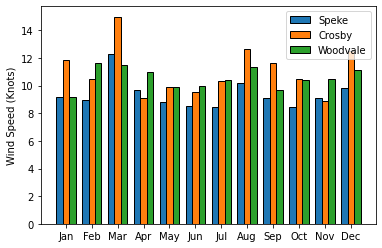

In [9]:
r = monthly_mean.index
width = 0.25

bar1 = plt.bar(r - width, monthly_mean["S0"], width = width, edgecolor = 'black',label='Speke')
bar2 = plt.bar(r, monthly_mean["S1"], width = width, edgecolor = 'black',label='Crosby')
bar3 = plt.bar(r + width, monthly_mean["S2"], width = width, edgecolor = 'black',label='Woodvale')

plt.legend( (bar1, bar2, bar3), ('Speke', 'Crosby', 'Woodvale') )
plt.xticks(r, calendar.month_abbr[1:13])
plt.ylabel("Wind Speed (Knots)")
plt.show()

In [10]:
##hourly mean
hourly_mean = pd.DataFrame()
for j in ["S0","S1","S2"]:
    m = list()
    for i in range(0,24):
        x = xy[j][(xy['Time'].dt.hour == i)].mean()
        m.append(round(x,4))
    m = list(m)
    hourly_mean[j] = m

hourly_mean

,S0,S1,S2
0,8.1193,10.4192,NaN
1,8.0986,10.4521,NaN
2,8.3195,10.4192,NaN
3,8.2196,10.4877,NaN
4,8.2274,10.4192,NaN
5,8.5000,10.4932,NaN
6,8.6618,10.6932,NaN
7,8.9621,10.8247,8.5344
8,9.1224,10.9589,9.7291
9,9.5813,11.2857,10.1757


In [11]:
cor_li = pd.DataFrame()
xx = midas_data_re
for i in ["S0","S1","S2"]:
    ll = []
    for k in range(0,11):
        co = round(xx[i].corr(xx[i].shift(k, fill_value=0)),4)
        ll.append(co)
    cor_li[i] = np.log(ll)
cor_li

,S0,S1,S2
0,0.000000,0.000000,0.000000
1,-0.138458,-0.081319,-0.184404
2,-0.226650,-0.136278,-0.270366
3,-0.316082,-0.188501,-0.362837
4,-0.406916,-0.242581,-0.459024
5,-0.500380,-0.295714,-0.571107
6,-0.598929,-0.349416,-0.643595
7,-0.688160,-0.406165,-0.730641
8,-0.788777,-0.459974,-0.823712
9,-0.882131,-0.510159,-0.944176


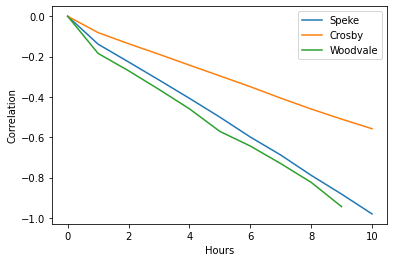

In [12]:
pl1 = plt.plot(cor_li.index,cor_li["S0"],label = "Speke")
pl2 = plt.plot(cor_li.index,cor_li["S1"],label = "Crosby")
pl3 = plt.plot(cor_li.index,cor_li["S2"],label = "Woodvale")
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Correlation")
plt.show()

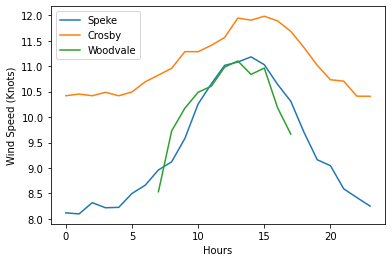

In [13]:
pl1 = plt.plot(hourly_mean.index,hourly_mean["S0"],label = "Speke")
pl2 = plt.plot(hourly_mean.index,hourly_mean["S1"],label = "Crosby")
pl3 = plt.plot(hourly_mean.index,hourly_mean["S2"],label = "Woodvale")
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Wind Speed (Knots)")
plt.show()

In [14]:
from windrose import WindroseAxes

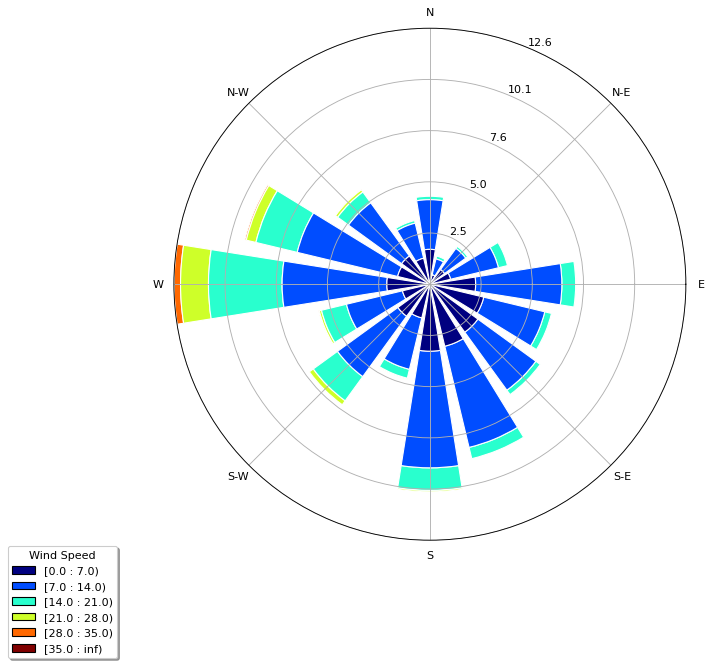

In [15]:
ax = WindroseAxes.from_ax() 
ax.bar(xy.D0, xy.S0, normed=True, opening=0.8, edgecolor='white')
ax.legend(shadow=True, bbox_to_anchor=[-0.1, 0], loc='upper right',title = "Wind Speed")

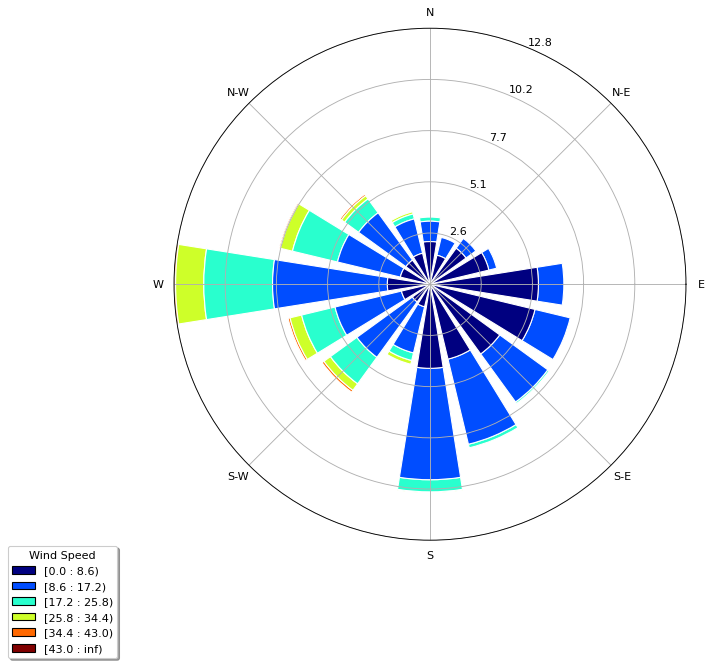

In [16]:
ax = WindroseAxes.from_ax() 
ax.bar(xy.D1, xy.S1, normed=True, opening=0.8, edgecolor='white')
ax.legend(shadow=True, bbox_to_anchor=[-0.1, 0], loc='upper right',title = "Wind Speed")

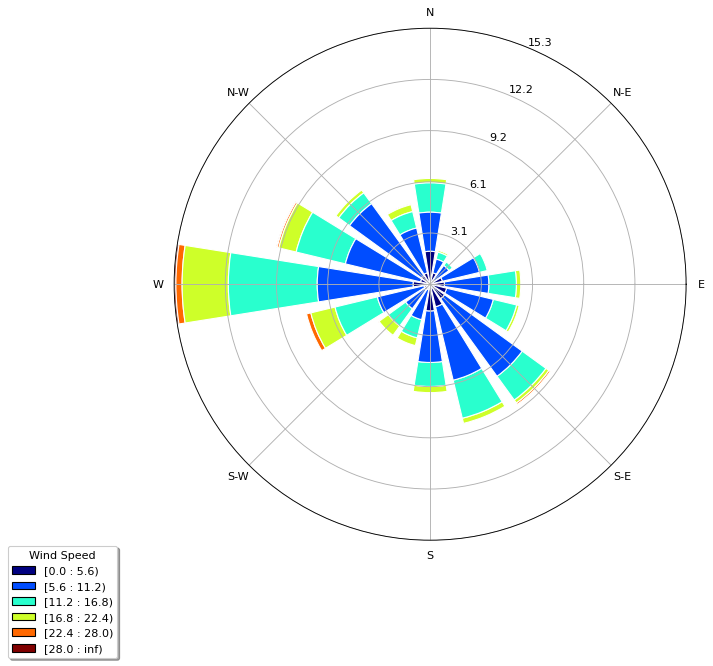

In [17]:
ax = WindroseAxes.from_ax() 
ax.bar(xy.D2, xy.S2, normed=True, opening=0.8, edgecolor='white')
ax.legend(shadow=True, bbox_to_anchor=[-0.1, 0], loc='upper right',title = "Wind Speed")

In [18]:
col = ["S0","S1","S2"]

speed_avg = midas_data_re[col].mean()
speed_avg

S0     9.380146
S1    11.030449
S2    10.419449
dtype: float64

In [19]:
midas_data_re[col].std()

S0    4.735269
S1    6.654116
S2    4.591029
dtype: float64

In [20]:
midas_data_re[col].max()

S0    35.0
S1    43.0
S2    28.0
dtype: float64

In [21]:
midas_data_re[col].skew(axis = 0, skipna = True)

S0    1.114725
S1    1.169930
S2    0.478837
dtype: float64

In [22]:
midas_data_re[col].kurtosis(axis = 0, skipna = True)

S0    1.796651
S1    1.448442
S2    0.429394
dtype: float64

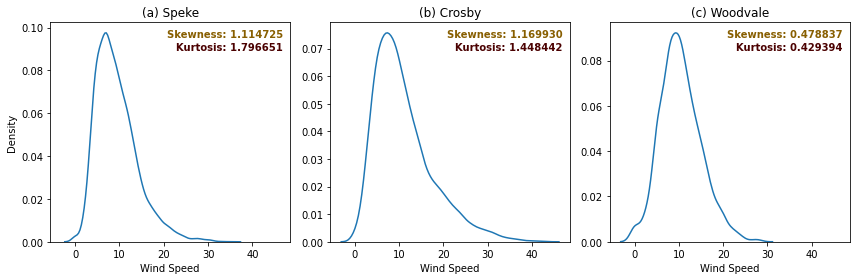

In [23]:
f, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
p = sns.distplot(midas_data_re.iloc[:,0], ax = axes[0],hist = False,)
p1 = sns.distplot(midas_data_re.iloc[:,1],ax = axes[1],hist = False)
p2 = sns.distplot(midas_data_re.iloc[:,2],ax = axes[2],hist = False)
p.set(xlabel = 'Wind Speed', ylabel = 'Density')
p1.set(xlabel = 'Wind Speed')
p2.set(xlabel = 'Wind Speed')
axes[0].set_title("(a) Speke")
axes[1].set_title("(b) Crosby")
axes[2].set_title("(c) Woodvale")
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % midas_data_re.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % midas_data_re.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

# PCA method

In [24]:
x0 = midas_data_re["S0"] - speed_avg[0]
x1 = midas_data_re["S1"] - speed_avg[1]
x2 = midas_data_re["S2"] - speed_avg[2]

In [25]:
x2[152] + speed_avg[2]

13.0

In [26]:
m00 = (x0 * x0).mean()
m11 = (x1 * x1).mean()
m22 = (x2 * x2).mean()
m01 = (x0 * x1).mean()
m02 = (x0 * x2).mean()
m12 = (x1 * x2).mean()

In [27]:
m = np.array([[m00,m01,m02],[m01,m11,m12],[m02,m12,m22]])
m

array([[22.42004431, 23.9009645 , 14.76599217],
       [23.9009645 , 44.27219559, 21.79456444],
       [14.76599217, 21.79456444, 21.0663785 ]])

In [28]:
egn_val, egn_vector = np.linalg.eigh(m)

In [29]:
egn_val
lam = round(egn_val.max(),4)
lam

72.9717

In [30]:
egn_vector = -egn_vector
print(egn_vector)
mu = []
for i in [0,1,2]:
    jj = egn_vector[i,2]
    jj = round(jj,4)
    mu.append(jj)
mu

[[ 0.8486008  -0.20955836  0.48575917]
 [-0.2795135   0.60197789  0.74799387]
 [-0.44916465 -0.77052444  0.45226453]]


[0.4858, 0.748, 0.4523]

In [31]:
mu[0] ** 2 + mu[1] ** 2 + mu[2] ** 2 

1.00008093

divide by sqrt of 3.

## m1 all 3

In [32]:
first_pr_comp = midas_data_re["S0"] * mu[0] + midas_data_re["S1"] * mu[1] + midas_data_re["S2"] * mu[2]
print(pd.Series(first_pr_comp).dropna())
pr_comp_mean = round(pd.Series(first_pr_comp).mean(),4)
pr_comp_mean   ##missing value = 7038

152     15.0409
153     18.8989
154     23.2143
155     29.8742
156     32.5370
         ...   
8460    16.6039
8481     6.5543
8482     6.4487
8483    11.9928
8484    16.8945
Length: 1722, dtype: float64


18.2824

In [33]:
print(midas_data_re.shape)
midas_data_re.head()

(8760, 7)


,S0,S1,S2,D0,D1,D2,Time
0,15.0,16.0,NaN,270.0,260.0,NaN,2019-01-01 00:00:00
1,12.0,17.0,NaN,270.0,260.0,NaN,2019-01-01 01:00:00
2,13.0,19.0,NaN,270.0,260.0,NaN,2019-01-01 02:00:00
3,14.0,19.0,NaN,280.0,270.0,NaN,2019-01-01 03:00:00
4,15.0,23.0,NaN,290.0,270.0,NaN,2019-01-01 04:00:00


## m2 2 sites

In [34]:
#expected S2

#missing value 0 
S0dif = list(midas_data_re["S0"].fillna(0,inplace = False) - midas_data_re["S0"].mean())
S1dif = list(midas_data_re["S1"].fillna(0,inplace = False) - midas_data_re["S1"].mean())
vec1 = np.column_stack((S0dif,S1dif))
vec2 = np.linalg.inv(np.array([[m00,m01],[m01,m11]]))
vec3 = np.array([lam*mu[0],lam*mu[1]])
print(vec1.shape,vec2.shape,vec3.shape)
gwynt_pca = pr_comp_mean + np.matmul(vec1,np.matmul(vec2,vec3))
gwynt_pca[~np.isnan(gwynt_pca)].mean()
gwynt_pca = gwynt_pca/np.sqrt(3)

(8760, 2) (2, 2) (2,)


## m3 1 site

In [35]:
s2 = midas_data_re["S0"] - midas_data_re["S0"].mean() + pr_comp_mean
print(len(s2))
np.isnan(np.array(s2)).sum()
s2[~np.isnan(s2)].mean()

8760


18.282399999999445

In [36]:
xy = midas_data_re
corr_01 = round(xy["S0"].corr(xy["S1"]),4)
corr_02 = round(xy["S0"].corr(xy["S2"]),4)
corr_12 = round(xy["S1"].corr(xy["S2"]),4)
corr_01, corr_02, corr_12

(0.7582, 0.7268, 0.8181)

# idw

In [37]:
coor0 = (53.5674,-3.04953)
coor1 = (53.497,-3.0563)
coor2 = (53.3316,-2.8455)
coor3 = (53.45,-3.58)

In [38]:
print(round(mpu.haversine_distance(coor0, coor1),2))
print(round(mpu.haversine_distance(coor0, coor2),2))
print(round(mpu.haversine_distance(coor1, coor2),2))
print(round(mpu.haversine_distance(coor0, coor3),2))
print(round(mpu.haversine_distance(coor1, coor3),2))
print(round(mpu.haversine_distance(coor2, coor3),2))

7.84
29.5
23.1
37.43
35.05
50.45


In [39]:
import leaflet
my_map = folium.Map(location = (53.0, -3.0), zoom_start = 8,tiles='cartodbpositron')

#Display the map
folium.Marker(coor0, popup = "Speke").add_to(my_map)
folium.Marker(coor1, popup = 'Crosby').add_to(my_map)
folium.Marker(coor2, popup = 'Woodvale').add_to(my_map)
folium.Marker(coor3, popup = 'Gwynt y Mor').add_to(my_map)

my_map

In [40]:
x = (coor0, coor1, coor2)
dist = []
for i in x:
    d = mpu.haversine_distance(coor3,i)
    dist.append(round(d,4))
print(dist)   

col2 = ["D0","D1","D2"]
weights = []
gam = 0.75
for i in (0,1,2):
    w = (dist[i]**gam)*(1+midas_data_re[col2[i]])
    weights.append(w)


for i in (0,1,2):
    rep = sum(weights[i][~np.isnan(weights[i])])/len(weights[2])
    s = np.isnan(weights[i])
    weights[i][s] = rep

[37.4289, 35.0515, 50.4535]


In [41]:
#inverse distance weighting
num = pd.DataFrame()
for i in (0,1,2):
    xy = 0
    w = weights[i]
    sp = midas_data_re[col[i]].fillna("n")
    zz = []
    for j in range(0,8760):
        if sp[j] =="n":
            sp[j] = 0.001
        mul = w[j]*sp[j]
        zz.append(mul)    
    num[i] = zz
final_num =  num[0] + num[1] + num[2]
exp_gwynt = pd.Series(final_num/sum(weights))
mean_ws = exp_gwynt.mean()
std_ws = round(np.std(exp_gwynt),4)
mean_ws, std_ws

(8.91651368368329, 5.1038)

## add gym pca and idw and interpolate

In [42]:
midas_data_re["gwynt_pca"] = gwynt_pca
midas_data_re["gwynt_idw"] = exp_gwynt


#interpolate
midas_data_inter = midas_data_re.set_index("Time").resample('30T').interpolate()
midas_data_inter.shape

(17519, 8)

In [43]:
midas_data_inter["Time"] = midas_data_inter.index

indd = pd.Series(range(0,17519))
midas_data_inter.set_index(indd, inplace = True)
midas_data_inter.head()

,S0,S1,S2,D0,D1,D2,gwynt_pca,gwynt_idw,Time
0,15.0,16.0,NaN,270.0,260.0,NaN,15.158638,13.993792,2019-01-01 00:00:00
1,13.5,16.5,NaN,270.0,260.0,NaN,14.872185,13.502529,2019-01-01 00:30:00
2,12.0,17.0,NaN,270.0,260.0,NaN,14.585731,13.011267,2019-01-01 01:00:00
3,12.5,18.0,NaN,270.0,260.0,NaN,15.283074,13.679525,2019-01-01 01:30:00
4,13.0,19.0,NaN,270.0,260.0,NaN,15.980416,14.347783,2019-01-01 02:00:00


# Weibull dist

In [44]:
sh_month = pd.DataFrame()
sc_month = pd.DataFrame()
all_col = ["S0","S1","S2","gwynt_pca","gwynt_idw"]
for j in all_col:
    shape = list()
    scale = list()
    for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
        par = stats.weibull_min.fit(midas_data_inter[j][(midas_data_inter['Time'].dt.month == i) & (midas_data_inter[j] > 0)],floc = 0)
        shape.append(round(par[0],2))
        scale.append(round(par[2],2))
    sh_month[j] = shape
    sc_month[j] = scale

In [45]:
sh_month

,S0,S1,S2,gwynt_pca,gwynt_idw
0,1.73,1.67,2.74,1.97,1.62
1,2.06,1.83,7.59,2.21,1.84
2,1.85,1.73,2.69,2.03,1.80
3,2.14,1.79,3.33,2.23,1.80
4,2.55,2.20,3.42,2.80,2.16
5,2.52,2.04,2.55,2.68,2.19
6,2.36,2.07,3.23,2.52,2.19
7,2.46,2.27,2.68,2.79,2.35
8,2.14,1.90,2.53,2.36,1.95
9,2.56,1.86,2.73,2.57,2.07


In [46]:
sc_month

,S0,S1,S2,gwynt_pca,gwynt_idw
0,10.13,13.34,10.75,12.06,10.35
1,9.88,11.81,11.91,11.22,9.19
2,13.38,16.85,12.61,15.14,13.44
3,10.68,10.32,11.12,10.71,9.01
4,9.69,11.20,10.58,10.71,9.17
5,9.37,10.77,11.07,10.41,8.90
6,9.41,12.02,10.69,10.78,9.67
7,11.35,14.24,12.85,12.95,11.50
8,9.91,13.13,11.85,11.87,10.32
9,9.30,11.83,10.88,11.03,9.49


In [47]:
sh = []
sc = []
for i in all_col:
    par = stats.weibull_min.fit(midas_data_inter[i][midas_data_inter[i] > 0],floc = 0)
    sh.append(round(par[0],2))
    sc.append(round(par[2],2))
    
print("shape: ",sh)
print("scale: ",sc)

shape:  [2.09, 1.8, 2.72, 2.22, 1.86]
scale:  [10.35, 12.5, 11.57, 11.69, 10.06]


# weibull dist graph

In [48]:
#site0
q0 = np.arange(0, 35, 0.1)
pdf0 = stats.weibull_min.pdf(q0, sh[0], loc=0, scale=sc[0])

In [49]:
#site1
q1 = np.arange(0, 40, 0.1)
pdf1 = stats.weibull_min.pdf(q1, sh[1], loc=0, scale=sc[1])

In [50]:
#site2
q2 = np.arange(0, 60, 0.1)
pdf2 = stats.weibull_min.pdf(q2, sh[2], loc=0, scale=sc[2])

Text(0.5, 1.0, '(c) Woodvale')

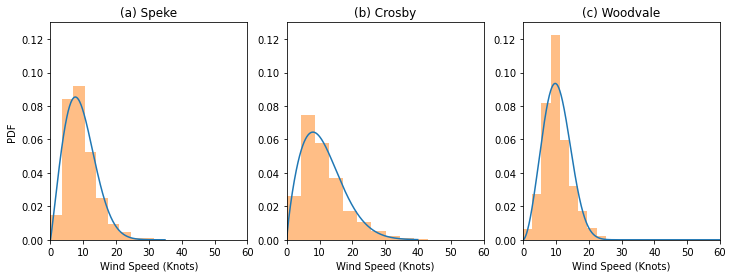

In [51]:
f, (axes1,axes2,axes3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
axes1.plot(q0, pdf0)
axes1.hist(midas_data_inter[all_col[0]], density=True, alpha=0.5)
axes1.set_xlim([0, 60])
axes1.set_ylabel("PDF")
axes1.set_xlabel("Wind Speed (Knots)")
axes1.set_ylim([0.00,0.13])
axes1.set_title("(a) Speke")

axes2.plot(q1, pdf1)
axes2.hist(midas_data_inter[all_col[1]], density=True, alpha=0.5)
axes2.set_xlim([0, 60])
axes2.set_ylim([0.00,0.13])
axes2.set_xlabel("Wind Speed (Knots)")
axes2.set_title("(b) Crosby")

axes3.plot(q2, pdf2)
axes3.hist(midas_data_inter[all_col[2]], density=True, alpha=0.5)
axes3.set_xlim([0, 60])
axes3.set_ylim([0.00,0.13])
axes3.set_xlabel("Wind Speed (Knots)")
axes3.set_title("(c) Woodvale")



Text(0.5, 1.0, '(e) Gwynt y Mor: IDW')

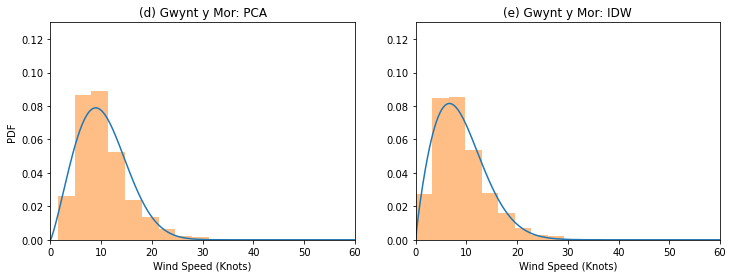

In [108]:
#gwynt y mor pca

f, (axes1,axes2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

q3 = np.arange(0, 60, 0.1)
pdf3 = stats.weibull_min.pdf(q3, sh[3], loc=0, scale=sc[3])

axes1.plot(q3, pdf3)
axes1.hist(midas_data_inter[all_col[3]], density=True, alpha=0.5)
axes1.set_xlim([0, 60])
axes1.set_ylabel("PDF")
axes1.set_xlabel("Wind Speed (Knots)")
axes1.set_ylim([0.00,0.13])
axes1.set_title("(d) Gwynt y Mor: PCA")


q4 = np.arange(0, 60, 0.1)
pdf4 = stats.weibull_min.pdf(q4, sh[4], loc=0, scale=sc[4])

axes2.plot(q4, pdf4)
axes2.hist(midas_data_inter[all_col[4]], density=True, alpha=0.5)
axes2.set_xlim([0, 60])
axes2.set_xlabel("Wind Speed (Knots)")
axes2.set_ylim([0.00,0.13])
axes2.set_title("(e) Gwynt y Mor: IDW")

In [53]:
hourly_mean_gwynt = pd.DataFrame()
for j in all_col:
    m = list()
    for i in range(0,24):
        x = midas_data_inter[j][(midas_data_inter['Time'].dt.hour == i)].mean()
        m.append(round(x,4))
    m = list(m)
    hourly_mean_gwynt[j] = m

hourly_mean_gwynt

,S0,S1,S2,gwynt_pca,gwynt_idw
0,7.9760,10.4274,10.0619,9.6658,7.8385
1,7.9345,10.4438,10.0133,9.6310,7.8242
2,8.0486,10.4363,9.9648,9.6301,7.8265
3,7.9992,10.4705,9.9163,9.6294,7.8183
4,8.0979,10.4377,9.8678,9.6597,7.8756
5,8.2969,10.5432,9.8192,9.7616,7.9903
6,8.4566,10.7260,9.7707,9.9543,8.2724
7,8.7065,10.8582,9.7992,10.1143,8.8785
8,8.8549,11.0377,10.0683,10.2220,9.2441
9,9.3201,11.2786,10.3256,10.4723,9.5970


In [54]:
monthly_mean_gwynt = pd.DataFrame()
for j in all_col:
    m = list()
    for i in range(1,13):
        x = midas_data_inter[j][(midas_data_inter['Time'].dt.month == i)].mean()
        m.append(round(x,4))
    m = list(m)
    monthly_mean_gwynt[j] = m

monthly_mean_gwynt

,S0,S1,S2,gwynt_pca,gwynt_idw
0,8.7742,11.8572,9.2069,10.6422,9.2596
1,8.7068,10.4457,11.1806,9.9215,8.1417
2,11.8337,14.9825,11.1586,13.3600,11.9301
3,9.4309,9.0972,10.0140,9.4742,7.9754
4,8.5618,9.8780,9.4894,9.5351,8.1486
5,8.2851,9.5149,9.7856,9.2511,7.8816
6,8.3125,10.2665,9.5899,9.5449,8.5637
7,9.9909,12.6072,11.4069,11.5178,10.2142
8,8.7385,11.6128,10.4683,10.4914,9.1427
9,8.2396,10.4479,9.6727,9.7680,8.3834


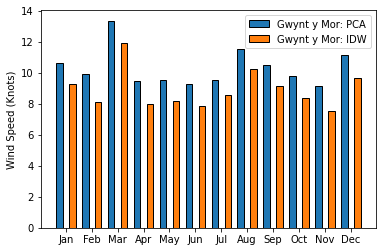

In [109]:
r = monthly_mean_gwynt.index
width = 0.25

bar1 = plt.bar(r - width, monthly_mean_gwynt["gwynt_pca"], width = width, edgecolor = 'black',label='Gwynt y Mor: PCA')
bar2 = plt.bar(r + width, monthly_mean_gwynt["gwynt_idw"], width = width, edgecolor = 'black',label='Gwynt y Mor: IDW')


plt.legend( (bar1, bar2), ('Gwynt y Mor: PCA','Gwynt y Mor: IDW') )
plt.xticks(r, calendar.month_abbr[1:13])
plt.ylabel("Wind Speed (Knots)")
plt.show()

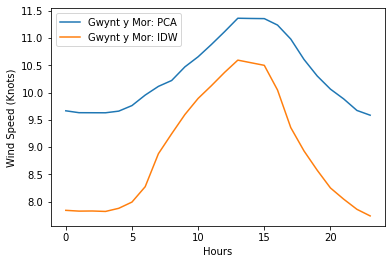

In [111]:
pl1 = plt.plot(hourly_mean_gwynt["gwynt_pca"], label='Gwynt y Mor: PCA')
pl2 = plt.plot(hourly_mean_gwynt["gwynt_idw"], label='Gwynt y Mor: IDW')


plt.legend()
plt.ylabel("Wind Speed (Knots)")
plt.xlabel("Hours")
plt.show()

# erf approximation

In [57]:
a = 8*(np.pi-3)/(3*np.pi*(4-np.pi))
c = ((1-2/np.pi)/a) -np.log(2)
d = (4/np.pi - 1) / a**2
x = pd.DataFrame()
w = pd.DataFrame()
u = pd.DataFrame()
v = pd.DataFrame()
y = pd.DataFrame()
for i in (0,1,2,3,4):
    x[i] = (midas_data_inter[all_col[i]]/scale[i])**(shape[i]/2)
    w[i] = -np.log(1- np.exp(x[i]**2))
    u[i] = ((w[i].fillna(0.01))**2 + x[i]**2)/2 + c
    v[i] = np.sqrt(u[i]**2 + d) + u[i] - 1/a
    y[i] = np.sqrt(v[i])*np.sign(x[i]-np.sqrt(np.log(2)))
print(a,c,d)
y.mean()

0.1400122886866665 1.9021980640680263 13.938346077519435


0        -inf
1        -inf
2        -inf
3    0.914039
4    1.065237
dtype: float64

In [58]:
cor_li = []
for i in (3,4):
    for k in range(1,11):
        co = round(y[i].corr(y[i].shift(k, fill_value=0)),4)
        cor_li.append(round(co**(1/k),2))
m = round(pd.Series(cor_li).mean(),4)
m

0.951

# Wind speed modelling

In [59]:
#theta 
theta_30 =  round(-np.log(m)/(0.5*0.5),4)

print(theta_30)

0.201


In [60]:
#alpha
alpha_30 = round(np.exp(-theta_30*0.5),4)

print(alpha_30)

0.9044


In [61]:
# beta
beta_30 = round(np.sqrt(1 - alpha_30**2),4)

print(beta_30)

0.4267


In [62]:
# random normol value
np.random.seed(123)
xi = np.random.normal(0,1,17519)
xi

array([-1.0856306 ,  0.99734545,  0.2829785 , ..., -1.23506112,
        0.0085973 , -0.34342489])

In [63]:
#pca #m=30
y_30 = [xi[0]]
for i in range(1,17519):
    ll = alpha_30*y_30[i-1] + beta_30*xi[i]
    y_30.append(ll)

In [64]:
#speed #pca #m=30
s_30 = []
for i in y_30:
    spd = stats.weibull_min.ppf(stats.norm.cdf(i),c = 2.22,loc = 0, scale = 11.69)
    s_30.append(spd)
mean_30, std_30 = round(np.mean(s_30),4), round(np.std(s_30),4)
mean_30, std_30

(10.6902, 5.1455)

In [65]:
start = datetime(2019,1,1,0,0,0)
end = datetime(2019,12,31,23,30,0)
seconds = (end - start).total_seconds()
step = timedelta(minutes=30)
array = []
for i in range(0, int(seconds), int(step.total_seconds())):
     array.append(start + timedelta(seconds=i))

In [66]:
Time = pd.Series(array)
model_gwynt = pd.Series(s_30)

model_data = pd.concat([Time,model_gwynt],axis=1)
model_data = model_data.rename(columns={0: "Time", 1: "speed"})
model_data

,Time,speed
0,2019-01-01 00:00:00,4.965580
1,2019-01-01 00:30:00,7.201114
2,2019-01-01 01:00:00,8.013723
3,2019-01-01 01:30:00,5.346134
4,2019-01-01 02:00:00,4.755301
...,...,...
17514,2019-12-31 21:00:00,8.227281
17515,2019-12-31 21:30:00,7.653855
17516,2019-12-31 22:00:00,5.534946
17517,2019-12-31 22:30:00,5.921621


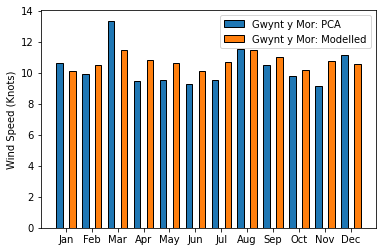

In [112]:
model_month = []
for i in range(1,13):
    x = model_data["speed"][(model_data['Time'].dt.month == i)].mean()
    model_month.append(x)
        
r = monthly_mean_gwynt.index
width = 0.25

bar1 = plt.bar(r - width, monthly_mean_gwynt["gwynt_pca"], width = width, edgecolor = 'black',label='Gwynt y Mor: PCA')
bar2 = plt.bar(r + width, model_month, width = width, edgecolor = 'black',label="Gwynt y Mor: Modelled")
plt.legend( (bar1, bar2), ('Gwynt y Mor: PCA','Gwynt y Mor: Modelled') )
plt.xticks(r, calendar.month_abbr[1:13])
plt.ylabel("Wind Speed (Knots)")
plt.show()

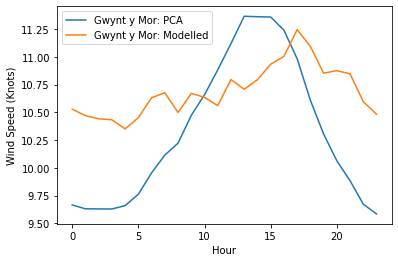

In [113]:
model_hour = []
for i in range(0,24):
    x = model_data["speed"][(model_data['Time'].dt.hour == i)].mean()
    model_hour.append(x)
        
pl1 = plt.plot(hourly_mean_gwynt["gwynt_pca"], label='Gwynt y Mor: PCA')
pl2 = plt.plot(range(0,24), model_hour, label='Gwynt y Mor: Modelled')
plt.ylabel("Wind Speed (Knots)")
plt.xlabel("Hour")
plt.legend()
plt.show()

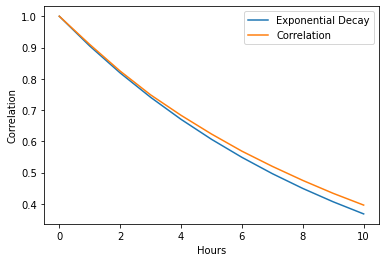

In [69]:
model_cor = []
est_co = []
for k in range(0,11):
    co = round(model_data["speed"].corr(model_data["speed"].shift(k, fill_value=0)),4)
    co1 = round(hourly_mean_gwynt["gwynt_pca"].corr(hourly_mean_gwynt["gwynt_pca"].shift(k, fill_value=0)),4)
    model_cor.append(co)
    est_co.append(co1)
    
pl1 = plt.plot(range(0,11), np.exp(-0.1*np.arange(0,11)), label = "Exponential Decay")
pl2 = plt.plot(range(0,11), model_cor, label = "Correlation")
plt.xlabel("Hours")
plt.ylabel("Correlation")
plt.legend()
plt.show()

In [70]:
model_data["speed"].isna().sum()

0

In [71]:
model_par = stats.weibull_min.fit(model_data["speed"][model_data["speed"] > 0],floc = 0)
model_shape = round(model_par[0],2)
model_scale = round(model_par[2],2)

In [72]:
model_shape, model_scale

(2.19, 12.07)

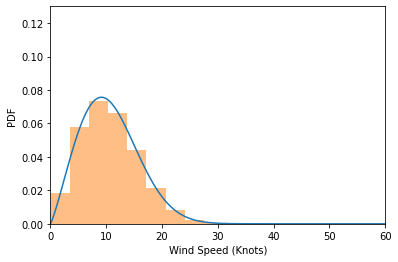

In [73]:
q5 = np.arange(0, 60, 0.1)
pdf5 = stats.weibull_min.pdf(q5, model_shape, loc=0, scale=model_scale)

plt.plot(q5, pdf5)
plt.hist(model_data["speed"], density=True, alpha=0.5)
plt.xlim([0, 60])
plt.ylabel("PDF")
plt.xlabel("Wind Speed (Knots)")
plt.ylim([0.00,0.13])
plt.show()

# Curtailment data

In [74]:
df = pd.read_excel('Curtailment TimeSeries.xlsx')

# Drop irrelevant columns
df.drop(df.columns[5:], axis=1, inplace=True)

In [75]:
# Use shorter column names
rn = {"Settlement Date": "sett_date",
      "Settlement Period": "sett_period",
      "Datetime": "Time",
      "Percentage Curtailment": "curt_perc",
      "Percentage of wind farm max energy produced": "energy_perc"
      }

df.rename(columns=rn, inplace=True)
df['Time'] = pd.to_datetime(df['Time'],format='%H:%M')
df['Time'] = df["Time"].dt.round('1s')
df.tail()

,sett_date,sett_period,Time,curt_perc,energy_perc
35083,2020-12-31,44,2020-12-31 22:00:00,0.0,0.954861
35084,2020-12-31,45,2020-12-31 22:30:00,0.0,5.763889
35085,2020-12-31,46,2020-12-31 23:00:00,0.0,9.562500
35086,2020-12-31,47,2020-12-31 23:30:00,0.0,11.895833
35087,2020-12-31,48,2021-01-01 00:00:00,0.0,4.489583


In [76]:
yr_2019 = df[df["Time"].dt.year == 2019]
yr_2020 = df[df["Time"].dt.year == 2020]

In [77]:
l_2019 = []
l_2020 = []
for i in range(1,13,1):
    x = yr_2019[yr_2019["Time"].dt.month == i].mean()
    l_2019.append(round(x["curt_perc"],4))
    
for i in range(1,13,1):
    x = yr_2020[yr_2020["Time"].dt.month == i].mean()
    l_2020.append(round(x["curt_perc"],4))

In [78]:
x_2019 = pd.DataFrame(yr_2019["Time"].dt.month.unique())
x_2019["curt_perc"] = l_2019
x_2019.rename(columns = {0:"Month"},inplace = True)


x_2020 = pd.DataFrame(yr_2020["Time"].dt.month.unique())
x_2020["curt_perc"] = l_2020
x_2020.rename(columns = {0:"Month"},inplace = True)

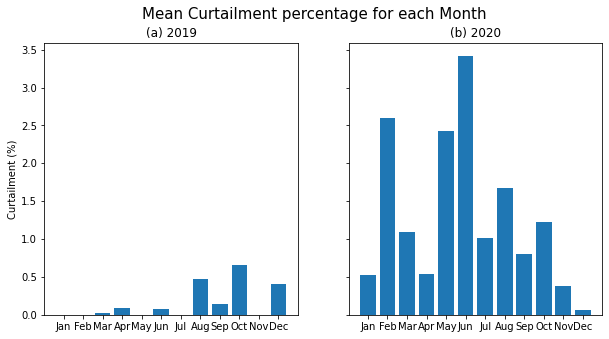

In [79]:
%matplotlib inline
fig , (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize = (10,5))
ax1.bar(x_2019["Month"],x_2019["curt_perc"])
ax1.set_ylabel('Curtailment (%)')
ax1.set_xticks(x_2019["Month"],calendar.month_abbr[1:])
ax1.set_title("(a) 2019")

ax2.bar(x_2020["Month"],x_2020["curt_perc"])
ax2.set_title("(b) 2020")
ax2.set_xticks(x_2020["Month"],calendar.month_abbr[1:])

plt.suptitle('Mean Curtailment percentage for each Month',fontsize = 15)
plt.show()

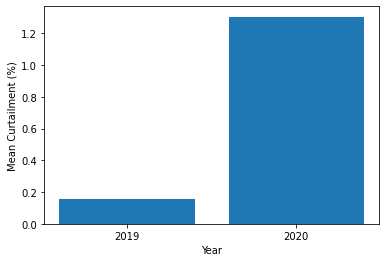

In [80]:
m_19 = df[df["Time"].dt.year == 2019]["curt_perc"].mean()
m_20 = df[df["Time"].dt.year == 2020]["curt_perc"].mean()
plt.bar((2019,2020),(m_19,m_20))
plt.xticks((2019,2020), ("2019","2020"))
plt.xlabel("Year")
plt.ylabel("Mean Curtailment (%)")
plt.show()

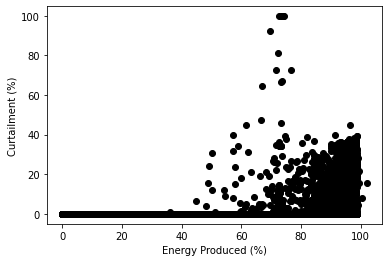

In [81]:
plt.scatter(df["energy_perc"],df["curt_perc"],c = "k")
plt.xlabel("Energy Produced (%)")
plt.ylabel('Curtailment (%)')
plt.show()

In [82]:
df[(df["curt_perc"] < 10) & (df["curt_perc"] > 1)]["energy_perc"].mean()

89.06522068798459

In [83]:
# Divide curtailment percentage into 4 bins:
# 0%, 1%-10%, 11%-20%, 20% and above
bins = [0, 0.001, 10, 20, 100]
df['curt_bin'] = pd.cut(df.curt_perc, bins, include_lowest=True, labels=False)

# Boolean column which is True when curtailment > 0
df['curt_bin_0'] = (df['curt_bin'] > 0)

# This column records the curtailment duration e.g. if there
# is curtailment in rows i,i-1,i-2,i-3 but not i-4 then
# row i in the duration column will be 4

## doubttttttt
df['dur'] = df['curt_bin'].groupby((df['curt_bin'] != df['curt_bin'].shift()).cumsum()).cumsum()
df['pc1'] = df['curt_perc'].shift(1, fill_value=0)
df['pcb1'] = df['curt_bin'].shift(1, fill_value=0)

dfc = df[df['curt_perc'] > 0]
dfc

,sett_date,sett_period,Time,curt_perc,energy_perc,curt_bin,curt_bin_0,dur,pc1,pcb1
3966,2019-03-24,31,2019-03-24 15:30:00,16.480572,95.686319,2,True,2,0.000000,0
3967,2019-03-24,32,2019-03-24 16:00:00,14.522822,91.211806,2,True,4,16.480572,2
5618,2019-04-28,1,2019-04-28 01:30:00,3.525981,97.572326,1,True,1,0.000000,0
5619,2019-04-28,2,2019-04-28 02:00:00,11.142801,96.858750,2,True,2,3.525981,1
5620,2019-04-28,3,2019-04-28 02:30:00,11.119050,96.805521,2,True,4,11.142801,2
...,...,...,...,...,...,...,...,...,...,...
34812,2020-12-26,13,2020-12-26 06:30:00,11.888859,72.040486,2,True,6,13.886229,2
34813,2020-12-26,14,2020-12-26 07:00:00,9.317661,72.666667,1,True,1,11.888859,2
34814,2020-12-26,15,2020-12-26 07:30:00,9.314990,72.687500,1,True,2,9.317661,1
34815,2020-12-26,16,2020-12-26 08:00:00,9.098745,72.506944,1,True,3,9.314990,1


# combining speed and curtailment

In [84]:
new_df = pd.merge(midas_data_inter,df, on = "Time")
new_df.head()

,S0,S1,S2,D0,D1,D2,gwynt_pca,gwynt_idw,Time,sett_date,sett_period,curt_perc,energy_perc,curt_bin,curt_bin_0,dur,pc1,pcb1
0,13.5,16.5,NaN,270.0,260.0,NaN,14.872185,13.502529,2019-01-01 00:30:00,2019-01-01,1,0.0,96.798611,0,False,0,0.0,0
1,12.0,17.0,NaN,270.0,260.0,NaN,14.585731,13.011267,2019-01-01 01:00:00,2019-01-01,2,0.0,92.131944,0,False,0,0.0,0
2,12.5,18.0,NaN,270.0,260.0,NaN,15.283074,13.679525,2019-01-01 01:30:00,2019-01-01,3,0.0,91.302083,0,False,0,0.0,0
3,13.0,19.0,NaN,270.0,260.0,NaN,15.980416,14.347783,2019-01-01 02:00:00,2019-01-01,4,0.0,92.052083,0,False,0,0.0,0
4,13.5,19.0,NaN,275.0,265.0,NaN,16.161881,14.610207,2019-01-01 02:30:00,2019-01-01,5,0.0,91.611111,0,False,0,0.0,0


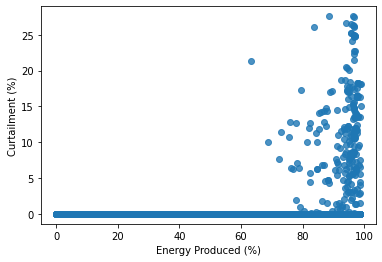

In [85]:
sns.regplot(y = new_df["curt_perc"],x = new_df["energy_perc"], scatter = True, fit_reg = False)
plt.ylabel("Curtailment (%)")
plt.xlabel("Energy Produced (%)")
plt.show()

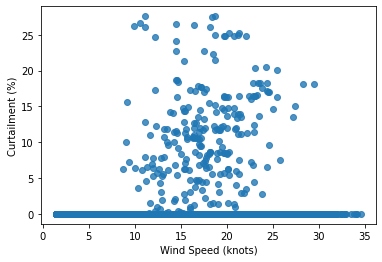

In [86]:
sns.regplot(y = new_df["curt_perc"],x = new_df["gwynt_pca"], scatter = True, fit_reg = False)
plt.ylabel("Curtailment (%)")
plt.xlabel("Wind Speed (knots)")
plt.show()

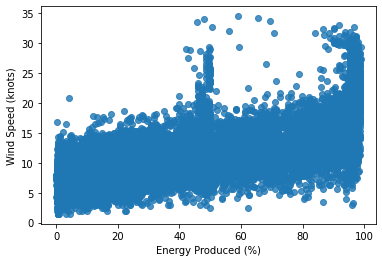

In [87]:
sns.regplot(x = new_df["energy_perc"],y = new_df["gwynt_pca"], scatter = True , fit_reg = False)
plt.xlabel("Energy Produced (%)")
plt.ylabel("Wind Speed (knots)")
plt.show()

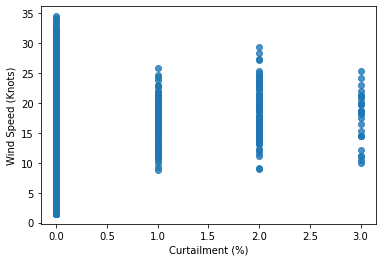

In [88]:
sns.regplot(x = new_df["curt_bin"],y = new_df["gwynt_pca"], scatter = True,  fit_reg=False)
plt.xlabel("Curtailment (%)")
plt.ylabel("Wind Speed (Knots)")
plt.show()

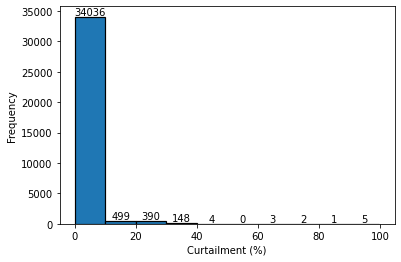

In [89]:
counts, edges, bars = plt.hist(df["curt_perc"], edgecolor='black', linewidth=1.2)
plt.xlabel("Curtailment (%)")
plt.ylabel("Frequency")
plt.bar_label(bars)
plt.show()

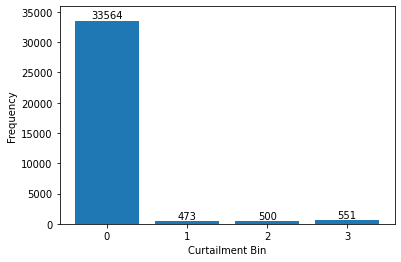

In [90]:
labels, counts = np.unique(df["curt_bin"], return_counts=True)
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.bar_label(bars)
plt.ylim([0,35900])
plt.xlabel("Curtailment Bin")
plt.ylabel("Frequency")
plt.show()

# neural network

In [91]:
rep_data = new_df.loc[:,("Time","gwynt_pca","curt_bin","pcb1")]

rep = rep_data[rep_data["curt_bin"] != 0]

rep_data = pd.concat([rep_data,rep,rep,rep,rep,rep,rep,rep,rep,rep,rep],ignore_index=True)
rep_data.tail()

,Time,gwynt_pca,curt_bin,pcb1
20013,2019-12-15 06:00:00,20.260393,1,1
20014,2019-12-23 03:00:00,19.189745,1,0
20015,2019-12-23 03:30:00,19.084755,1,1
20016,2019-12-23 04:00:00,18.979766,1,1
20017,2019-12-23 04:30:00,16.782748,1,1


In [92]:
data = np.array(rep_data["curt_bin"])
# one hot encode
xt = to_categorical(data)
xt = pd.DataFrame(xt)
for i in (0,1,2,3):
    xt[i+4] = 0
xt

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0,0,0,0
1,1.0,0.0,0.0,0.0,0,0,0,0
2,1.0,0.0,0.0,0.0,0,0,0,0
3,1.0,0.0,0.0,0.0,0,0,0,0
4,1.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
20013,0.0,1.0,0.0,0.0,0,0,0,0
20014,0.0,1.0,0.0,0.0,0,0,0,0
20015,0.0,1.0,0.0,0.0,0,0,0,0
20016,0.0,1.0,0.0,0.0,0,0,0,0


In [93]:
for i in np.arange(0,20018):
    for j in range(0,4):
        if xt.iloc[i,j] == 1:
            x = j+4
            xt.iloc[i,x] = np.log(rep_data.loc[i,"gwynt_pca"])
xt.shape

(20018, 8)

In [94]:
xt

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,2.699493,0.000000,0.0,0.0
1,1.0,0.0,0.0,0.0,2.680044,0.000000,0.0,0.0
2,1.0,0.0,0.0,0.0,2.726746,0.000000,0.0,0.0
3,1.0,0.0,0.0,0.0,2.771364,0.000000,0.0,0.0
4,1.0,0.0,0.0,0.0,2.782655,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
20013,0.0,1.0,0.0,0.0,0.000000,3.008668,0.0,0.0
20014,0.0,1.0,0.0,0.0,0.000000,2.954376,0.0,0.0
20015,0.0,1.0,0.0,0.0,0.000000,2.948890,0.0,0.0
20016,0.0,1.0,0.0,0.0,0.000000,2.943373,0.0,0.0


In [95]:
data = np.array(rep_data["pcb1"])
print(data)
# one hot encode
yt = to_categorical(data)
yt = pd.DataFrame(yt)
yt

[0 0 0 ... 1 1 1]


,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
20013,0.0,1.0,0.0,0.0
20014,1.0,0.0,0.0,0.0
20015,0.0,1.0,0.0,0.0
20016,0.0,1.0,0.0,0.0


In [96]:
np.random.seed(1335)
model = tensorflow.keras.Sequential([
    keras.Input(shape= (8)),
    keras.layers.Dense(4,use_bias=False,activation = "softmax")
])
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [97]:
np.random.seed(1335)
model.fit(xt ,yt, epochs=100)

Epoch 1/100
626/626 [==============================] - 6s 4ms/step - loss: 1.1930 - accuracy: 0.5126
Epoch 2/100
626/626 [==============================] - 2s 3ms/step - loss: 0.3140 - accuracy: 0.9594
Epoch 3/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1871 - accuracy: 0.9606
Epoch 4/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1517 - accuracy: 0.9606
Epoch 5/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1369 - accuracy: 0.9606
Epoch 6/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1296 - accuracy: 0.9606
Epoch 7/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1254 - accuracy: 0.9606
Epoch 8/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1229 - accuracy: 0.9606
Epoch 9/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1214 - accuracy: 0.9606
Epoch 10/100
626/626 [==============================] - 3s 5ms/step - loss: 0.1204 - accura

626/626 [==============================] - 2s 3ms/step - loss: 0.1154 - accuracy: 0.9606
Epoch 82/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1154 - accuracy: 0.9606
Epoch 83/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1154 - accuracy: 0.9606
Epoch 84/100
626/626 [==============================] - 1s 2ms/step - loss: 0.1154 - accuracy: 0.9606
Epoch 85/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1153 - accuracy: 0.9606
Epoch 86/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1153 - accuracy: 0.9606
Epoch 87/100
626/626 [==============================] - 1s 2ms/step - loss: 0.1153 - accuracy: 0.9606
Epoch 88/100
626/626 [==============================] - 1s 2ms/step - loss: 0.1153 - accuracy: 0.9606
Epoch 89/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1152 - accuracy: 0.9606
Epoch 90/100
626/626 [==============================] - 2s 3ms/step - loss: 0.1153 - accuracy: 

In [98]:
np.random.seed(1335)
weights = model.layers[0].get_weights() #a_ij & b_ij

In [99]:
weights = np.array(weights).reshape((8,4))
A = weights[0:4,:].round(4)
B = weights[4:,:].round(4)
A,B

(array([[ 3.806 , -3.0446, -2.4786, -7.3017],
        [ 0.591 , -0.3912, -0.9192, -4.3334],
        [-0.6349, -0.0171,  0.1659, -0.3429],
        [-3.6694, -1.1637, -0.2968,  1.3325]], dtype=float32),
 array([[-0.2913, -0.1258, -1.0945, -6.5764],
        [-0.361 ,  0.3355, -0.0327, -5.1487],
        [-0.4655,  0.0494,  0.555 , -0.3423],
        [-4.5539, -0.0952, -0.0371,  0.1184]], dtype=float32))

In [100]:
log_s =  np.log(s_30)
log_s

array([1.60253007, 1.97423578, 2.0811555 , ..., 1.71108181, 1.77861024,
       1.73166887])

In [101]:
ws = np.arange(1,40,5)
ws = np.log(ws.round(4))
ws

array([0.        , 1.79175947, 2.39789527, 2.77258872, 3.04452244,
       3.25809654, 3.4339872 , 3.58351894])

In [102]:
fpd0 = pd.DataFrame()
for w in ws:
    uu = np.array([A[0,j] + B[0,j]*w for j in range(4)])
    pzz = (np.exp(uu) / np.sum(np.exp(uu)))
    fpd0[np.exp(w)] = pzz.round(4).tolist()
fpd0 = fpd0.T
fpd0

,0,1,2,3
1.0,0.9971,0.0011,0.0019,0.0
6.0,0.9981,0.0014,0.0004,0.0
11.0,0.9982,0.0016,0.0003,0.0
16.0,0.9981,0.0017,0.0002,0.0
21.0,0.9981,0.0017,0.0002,0.0
26.0,0.9981,0.0018,0.0001,0.0
31.0,0.9980,0.0019,0.0001,0.0
36.0,0.9980,0.0019,0.0001,0.0


In [103]:
fpd1 = pd.DataFrame()
pr = []
for w in ws:
    uu = np.array([A[1,j] + B[1,j]*w for j in range(4)])
    pzz = (np.exp(uu) / np.sum(np.exp(uu)))
    fpd1[np.exp(w)] = pzz.round(4).tolist()
fpd1 = fpd1.T
fpd1

,0,1,2,3
1.0,0.6240,0.2337,0.1378,0.0045
6.0,0.3701,0.4827,0.1472,0.0000
11.0,0.2878,0.5726,0.1397,0.0000
16.0,0.2420,0.6251,0.1328,0.0000
21.0,0.2118,0.6611,0.1271,0.0000
26.0,0.1899,0.6879,0.1222,0.0000
31.0,0.1731,0.7088,0.1181,0.0000
36.0,0.1597,0.7258,0.1144,0.0000


In [104]:
fpd2 = pd.DataFrame()
pr = []
for w in ws:
    uu = np.array([A[2,j] + B[2,j]*w for j in range(4)])
    pzz = (np.exp(uu) / np.sum(np.exp(uu)))
    fpd2[np.exp(w)] = pzz.round(4).tolist()
fpd2 = fpd2.T
fpd2

,0,1,2,3
1.0,0.1557,0.2889,0.3469,0.2085
6.0,0.0472,0.2201,0.6540,0.0788
11.0,0.0286,0.1826,0.7372,0.0515
16.0,0.0207,0.1600,0.7804,0.0390
21.0,0.0162,0.1443,0.8078,0.0316
26.0,0.0134,0.1327,0.8272,0.0267
31.0,0.0114,0.1235,0.8419,0.0232
36.0,0.0099,0.1161,0.8534,0.0206


In [105]:
fpd3 = pd.DataFrame()
pr = []
for w in ws:
    uu = np.array([A[3,j] + B[3,j]*w for j in range(4)])
    pzz = (np.exp(uu) / np.sum(np.exp(uu)))
    fpd3[np.exp(w)] = pzz.round(4).tolist()
fpd3 = fpd3.T
fpd3

,0,1,2,3
1.0,0.0052,0.0641,0.1526,0.7781
6.0,0.0000,0.0467,0.1232,0.8302
11.0,0.0000,0.0417,0.1140,0.8443
16.0,0.0000,0.0389,0.1086,0.8525
21.0,0.0000,0.0369,0.1048,0.8583
26.0,0.0000,0.0354,0.1019,0.8627
31.0,0.0000,0.0343,0.0996,0.8662
36.0,0.0000,0.0333,0.0976,0.8691


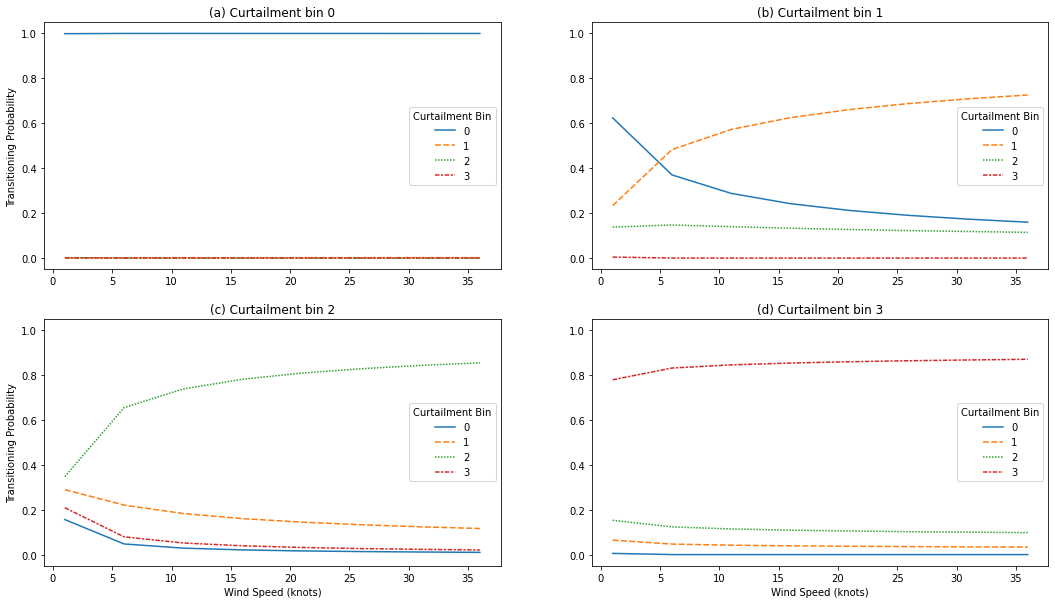

In [106]:
fpd0.index.name = fpd1.index.name = fpd2.index.name = fpd3.index.name = "wind speed"
fpd0.columns.name = fpd1.columns.name = fpd2.columns.name = fpd3.columns.name = "bins"

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.lineplot(data = fpd0, ax=axes[0, 0])
axes[0, 0].set(ylabel = "Transitioning Probability", title = "(a) Curtailment bin 0", xlabel=None)
axes[0, 0].legend(loc = "center right", title='Curtailment Bin')

sns.lineplot(data = fpd1, ax=axes[0, 1])
axes[0, 1].set(xlabel = None, title = "(b) Curtailment bin 1", ylim = (-0.04999000000000001, 1.04979))
axes[0, 1].legend(loc = "center right", title='Curtailment Bin')

sns.lineplot(data = fpd2, ax=axes[1, 0])
axes[1, 0].set(xlabel = "Wind Speed (knots)", ylabel = "Transitioning Probability", title = "(c) Curtailment bin 2",
               ylim = (-0.04999000000000001, 1.04979))
axes[1, 0].legend(loc = "center right", title='Curtailment Bin')

sns.lineplot(data = fpd3, ax=axes[1, 1])
axes[1, 1].set(xlabel = "Wind Speed (knots)", title = "(d) Curtailment bin 3",  ylim = (-0.04999000000000001, 1.04979))
axes[1, 1].legend(loc = "center right", title='Curtailment Bin')


In [107]:
for label, grp in fpd1.groupby('variable'):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-107-4e1983ca5990>, line 2)

In [ ]:
cc = np.array([1,0,0,0,1.559206,0,0,0]).reshape((1,8))
pre = np.rint(np.array(model.predict(cc)))

pre

In [ ]:
cc = np.array([0,1,0,0,0,2.65,0,0]).reshape((1,8))
pre = np.rint(np.array(model.predict(cc)))

pre

In [ ]:
curt_2020 = df[df["Time"].dt.year == 2020 ]
curt_2020 = curt_2020["curt_bin"][:17519]

data0 = np.array(curt_2020)
# one hot encode
test = to_categorical(data0)
test = pd.DataFrame(test)
for i in (0,1,2,3):
    test[i+4] = 0
test

for t in np.arange(0,17519):
    for i in range(0,4):
        if test.iloc[t,i] == 1:
            x = i+4
            test.iloc[t,x] = np.log(s_30[t])

In [ ]:
A

In [ ]:
log_st = np.log(2.21)
i = 0
u = np.array([A[i,j] + B[i,j]*log_st for j in range(4)])
p0 = np.exp(u) / np.sum(np.exp(u))
print(p0) 

In [ ]:
# i = 0
pred_curt = []
t = 3
i = data0[t]
log_st = log_s[t]
print(i)
print(log_st)
u = np.array([A[i,j] + B[i,j]*log_st for j in range(4)])
p0 = np.exp(u) / np.sum(np.exp(u))
print(p0) 

In [ ]:
# i = 1
pred_curt = []
t = 3238
i = data0[t]
log_st = log_s[t]
print(i)
print(log_st)
u = np.array([A[i,j] + B[i,j]*log_st for j in range(4)])
p1 = np.exp(u) / np.sum(np.exp(u))
print(p1)    

In [ ]:
# i = 2
pred_curt = []
t = 2895
i = data0[t]
log_st = log_s[t]
print(i)
print(log_st)
u = np.array([A[i,j] + B[i,j]*log_st for j in range(4)])
p2 = np.exp(u) / np.sum(np.exp(u))
print(p2)

In [ ]:
# i = 3
pred_curt = []
t = 1583
i = data0[t]
log_st = log_s[t]
print(i)
print(log_st)
u = np.array([A[i,j] + B[i,j]*log_st for j in range(4)])
p3 = np.exp(u) / np.sum(np.exp(u))
print(p3)

In [ ]:
# tp[i][j] is the transition probability from curtailment bin
# i to curtailment bin j (or the other way around?)
tp19 = np.around(np.array([[df[(df['pcb1'] == i) & (df['curt_bin'] == j)].shape[0] / ##n_ij
                df[df['pcb1'] == j].shape[0]   ##n_ik
                for j in range(4)] for i in range(4)]),3)
print(tp19)

In [ ]:
tp20 = np.vstack((p0,p1,p2,p3))
tp20.round(3)